# Combined Recent Surveys
This notebook make predictions for the combined features and cross border predictions.

In [1]:
cd ..

/Users/emmaboehly/Documents/Master1/Machine Learning/Projet2/MLProjet2/src


In [2]:
%autoreload 2
%load_ext autoreload
%matplotlib inline

UsageError: Line magic function `%autoreload` not found.


In [6]:
from lib import estimator_util as eu
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

In [4]:
sns.set_theme()

In [5]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")

## Heatmap for cross country

In [11]:
def run_combined(df, osm_cols, model, **params) :
    countries = [["NG"], ["ETH"] ,["TZA"], ["MW"], ["NG", "ETH", "TZA", "MW"]]
    results = np.zeros((5,5))
    for i, country in enumerate(countries):
        X, y = eu.get_recent_features(df, country, osm_cols)
        for j, out_country in enumerate(countries):
            X_out, y_out = eu.get_recent_features(df, out_country, osm_cols)
            r, _, m = eu.run_model_out(X, y, X_out, y_out, model, **params)
            results[i,j] = r
    return results

In [13]:
def heatmap(data):
    countries = ["Nigeria", "Ethiopia" ,"Tanzania", "Malawi", "Pooled"]
    df_cm = pd.DataFrame(data, index = countries, columns = countries)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cbar_kws={'label': r'$r^2$'})
    plt.xlabel("Country trained on")
    plt.ylabel("Country evaluated on")
    ax = plt.gca()
    plt.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig("../figs/cross_country_pooled.pdf", dpi=600, bbox_inches="tight")

### Using Ridge Regression to compare with the original model

In [14]:
ridge_results = run_combined(complete_df, all_cols, Ridge, alpha = 1000)

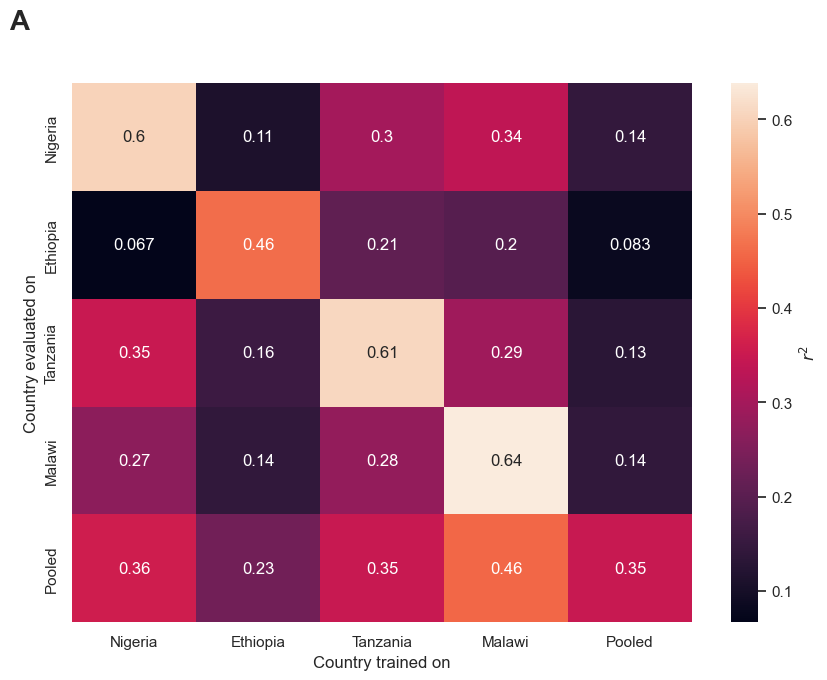

In [15]:
heatmap(ridge_results)

### Using CatBoost our best model

In [ ]:
catboost_results = run_combined(complete_df, all_cols, CatBoostRegressor)

In [ ]:
heatmap(catboost_results)

## Pooled Dataset

In [21]:
def plot_pooled_results(df, osm_cols, model, **params) :
    X, y = eu.get_recent_features(df, ["NG", "ETH", "TZA", "MW"], osm_cols, scale_cnn=False)
    r2, y_real, y_predicted, model = eu.run_model(X, y, model, **params)
    fig = eu.plot_predictions(y_real, y_predicted, r2, "Pooled", "max in Dataset")
    return fig, model

### with Ridge

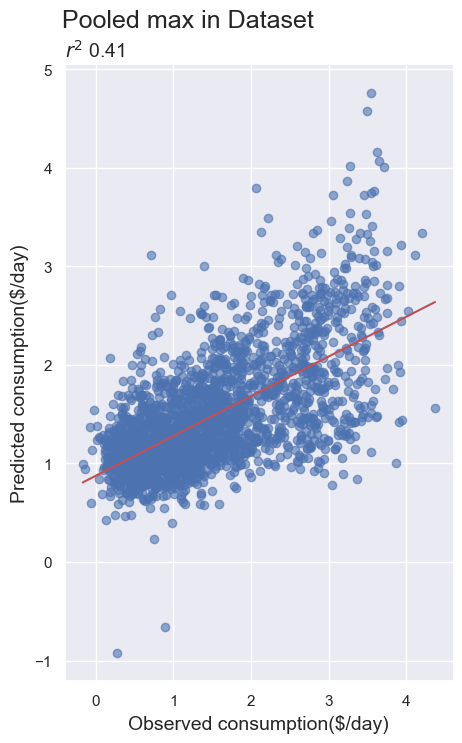

In [22]:
fig, _ = plot_pooled_results(complete_df, all_cols, Ridge, alpha = 1000)
fig.savefig("../figs/pooled_max_year_ridge.pdf", dpi=600, bbox_inches="tight")

### with CatBoost

In [ ]:
fig, model = plot_pooled_results(complete_df, all_cols, CatBoostRegressor)
fig.savefig("../figs/pooled_max_year_catboost.pdf", dpi=600, bbox_inches="tight")

In [24]:
def features_importance(model) :
    importance = model.feature_importances_
    cnn_features_names = [f'cnn{i}' for i in range(len(complete_df.features[0]))]
    features_names = np.concatenate((all_cols, cnn_features_names))
    mask = ~pd.Series(features_names).str.match(r'^cnn')
    
    fig, ax = plt.subplots(figsize=(10, 20))
    sorted_importance, sorted_features = zip(*sorted(zip(importance[mask], features_names[mask])))
    #sorted_importance, sorted_features = importance[mask], features_names[mask]
    ax.barh(sorted_features, sorted_importance)
    ax.set_yticklabels(sorted_features, fontsize=6)
    
    plt.xlabel('Importance', fontsize=14)
    plt.title(f'Features importance for all country', fontsize=18)    
    plt.show()

features_importance(model)

NameError: name 'model' is not defined